In [2]:
from prefect import task, get_run_logger
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


nltk.download('words')
from nltk.corpus import words

english_words = set(words.words())

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")


/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package words to /Users/azad/nltk_data...
[nltk_data]   Package words is already up-to-date!
/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [57]:
word_1 ='Gross weight (kg)'
word_2 ='weight'
! pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.0 MB/s eta 0:00:00


In [11]:
# Get emnedding of word 1
inputs_1 = tokenizer(word_1.lower(), return_tensors="pt", truncation=True, padding=True)
outputs_1 = model(**inputs_1)
embedding_1 = outputs_1.last_hidden_state.mean(dim=1).detach().numpy()

In [133]:
# Get emnedding of word 2
inputs_2 = tokenizer(word_2.lower(), return_tensors="pt", truncation=True, padding=True)
outputs_2 = model(**inputs_2)
embedding_2 = outputs_2.last_hidden_state.mean(dim=1).detach().numpy()

In [13]:
cosine_similarity(embedding_1, embedding_2)

array([[0.3544008]], dtype=float32)

In [1]:
# Get our data from pickle file
import pickle
with open('df.pkl', 'rb') as f:
   df1= pickle.load(f)

In [146]:
# Generate list of dataframes
frame_list = []
for data_f_list in dataframes:
    if isinstance(data_f_list, list):
        for item in data_f_list:
            frame_list.append(item)
    

In [55]:
len(frame_list)

8

In [147]:
# Check if column's name is a meaningful word ( sometimes it has more othan one word in header)
def is_meaningful_word(word):
     word_list  = word.split()
     for word in word_list:
        if word in english_words:
            if len(''.join(word_list)) > 3:
                return True
     return False



In [148]:
# Function to filter out columns with non-meaningful headers
def filter_columns(df):
    meaningful_columns = {}
    original_cols = []
    for col in df.columns:
        original_cols.append(col)
        cleaned_col = clean_header(col)
        if is_meaningful_word(cleaned_col):
            meaningful_columns[col] = df[col]
  
    return pd.DataFrame(meaningful_columns)

In [149]:
# Clean headers name by removing non-alphabetic chars
def clean_header(header):
    header = header.lower()
    header = re.sub(r'[^a-zA-Z0-9\s]', ' ', header)
    header = re.sub(r'\s+', ' ', header).strip()
    return header


In [150]:
# Function to convert each column of a DataFrame into a document, including the cleaned column name
def df_columns_to_documents(df, df_index):
    documents = {}
    for col in df.columns:
        cleaned_col = clean_header(col)
        doc_key = f"{df_index}_{cleaned_col}"
        doc_content = " ".join(cleaned_col.split() + df[col].astype(str).tolist())
        documents[doc_key] = doc_content
    return documents


In [151]:

# Apply the filter to each DataFrame
filtered_dfs = [filter_columns(df) for df in frame_list]

# Combine all documents from all DataFrames
all_documents = {}
for i, df in enumerate(filtered_dfs):
    all_documents.update(df_columns_to_documents(df, i))

# Prepare the list of documents and their keys
doc_keys = list(all_documents.keys())
doc_values = list(all_documents.values())

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents to generate the TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(doc_values)

# Compute cosine similarity between all documents
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a DataFrame to represent the similarity matrix
similarity_df = pd.DataFrame(cosine_sim, index=doc_keys, columns=doc_keys)


<Figure size 1800x1500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Cosine Similarity Matrix of Columns')

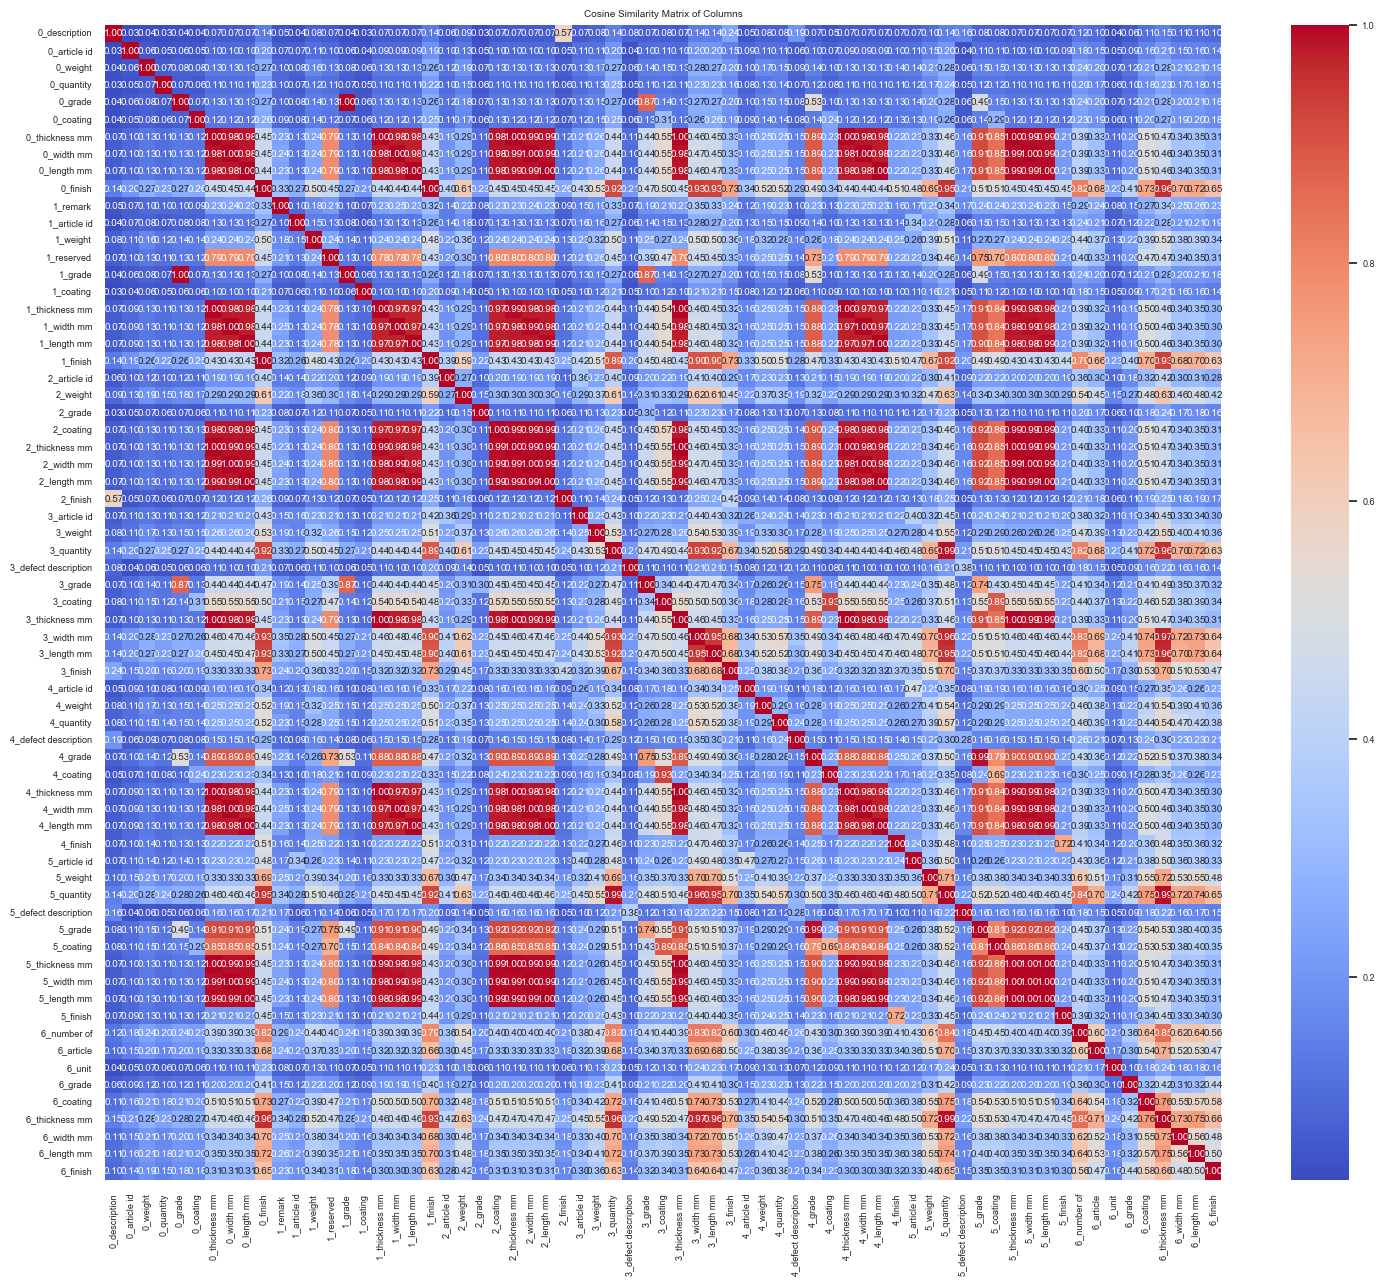

In [152]:
plt.figure(figsize=(18, 15))
sns.set(font_scale=.6)
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Cosine Similarity Matrix of Columns')
plt.show()

In [159]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Function to clean the column headers
def clean_header(header):
    header = header.lower()
    header = re.sub(r'[^a-zA-Z0-9\s]', ' ', header)
    header = re.sub(r'\s+', ' ', header).strip()
    return header

# Function to convert each column of a DataFrame into a document
def df_columns_to_documents(df, df_index):
    documents = {}
    original_names = {}
    for col in df.columns:
        cleaned_col = clean_header(col)
        doc_key = f"{df_index}_{cleaned_col}"
        doc_content = " ".join([cleaned_col] + df[col].astype(str).tolist())
        documents[doc_key] = doc_content
        original_names[doc_key] = col  # Store original column name
    return documents, original_names

# Function to calculate cosine similarity for hybrid model (TF-IDF + BERT) and visualize results
def calculate_and_visualize_hybrid_similarity(dfs, tfidf_weight=0.8, bert_weight=0.2, threshold=0.2):
    # Initialize models
    vectorizer = TfidfVectorizer()
    bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    
    all_documents = {}
    all_original_names = {}
    
    # Prepare documents and original names from all DataFrames
    for i, df in enumerate(dfs):
        documents, original_names = df_columns_to_documents(df, i)
        all_documents.update(documents)
        all_original_names.update(original_names)
    
    # Prepare the list of documents and their keys
    doc_keys = list(all_documents.keys())
    doc_values = list(all_documents.values())
    
    # TF-IDF Calculation
    tfidf_matrix = vectorizer.fit_transform(doc_values)
    tfidf_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # BERT Embedding Calculation
    bert_embeddings = bert_model.encode(doc_values, convert_to_tensor=True)
    bert_embeddings = [t.cpu().numpy() for t in bert_embeddings]
    bert_similarity = cosine_similarity(bert_embeddings, bert_embeddings)
    
    # Hybrid Similarity Calculation (Weighted Sum)
    hybrid_similarity = (tfidf_weight * tfidf_similarity) + (bert_weight * bert_similarity)
    
    # Convert the hybrid similarity matrix to a DataFrame
    hybrid_similarity_df = pd.DataFrame(hybrid_similarity, index=doc_keys, columns=doc_keys)
    
    # Visualization: Heatmap of the hybrid similarity matrix
    plt.figure(figsize=(20, 15))
    sns.set(font_scale=.6)
    sns.heatmap(hybrid_similarity_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title('Hybrid Similarity Matrix (TF-IDF + BERT)')
    plt.show()
    
    # Find and print similar column pairs based on the threshold
    matched_columns = []
    for i in range(len(hybrid_similarity)):
        for j in range(i+1, len(hybrid_similarity)):
            if hybrid_similarity[i, j] > threshold:
                col1 = all_original_names[doc_keys[i]]
                col2 = all_original_names[doc_keys[j]]
                similarity_score = hybrid_similarity[i, j]
                matched_columns.append((col1, col2, similarity_score))
    
    # Create a mapping of matched columns
    mapping_df = pd.DataFrame(matched_columns, columns=['Column 1', 'Column 2', 'Similarity'])
    
    return mapping_df



/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


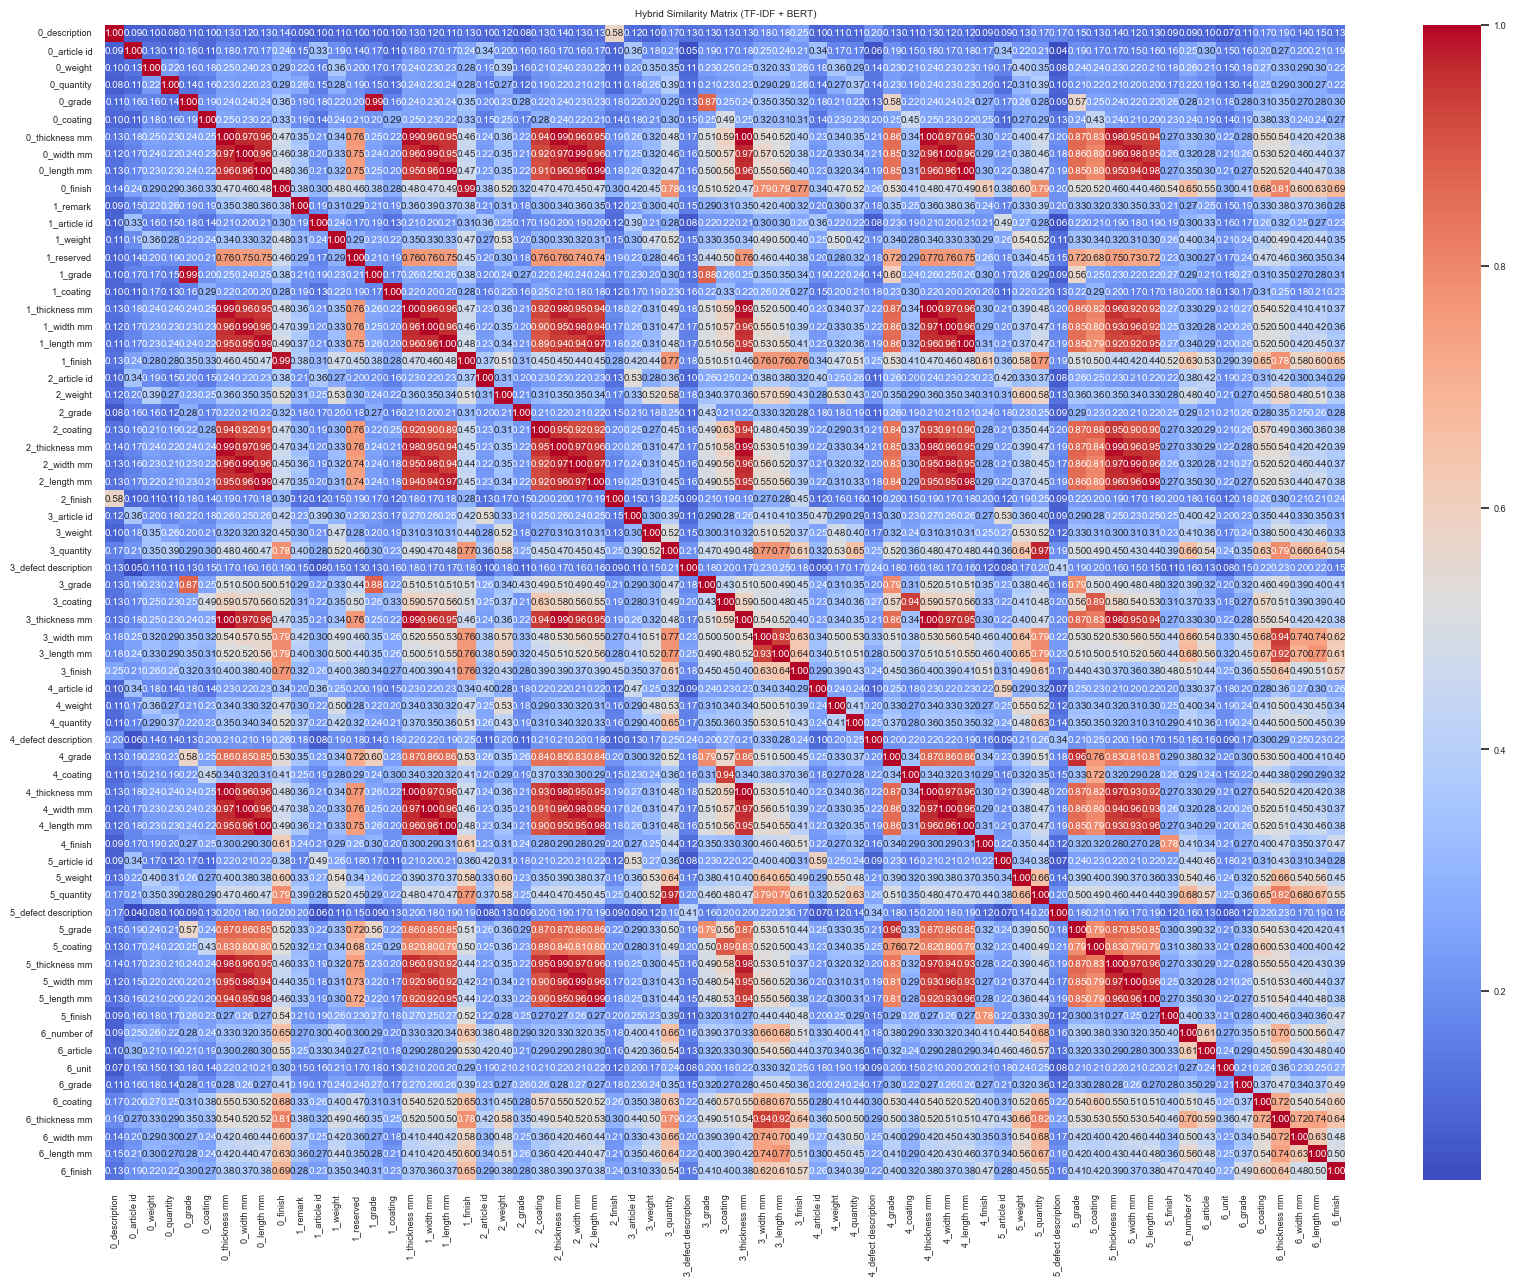

            Column 1     Column 2  Similarity
0        Description       Finish    0.577014
1        Description       Finish    0.249863
2         Article ID       Finish    0.242377
3         Article ID   Article ID    0.334571
4         Article ID       Finish    0.242399
...              ...          ...         ...
1781  Thickness (mm)  Length (mm)    0.740445
1782  Thickness (mm)       Finish    0.641834
1783      Width (mm)  Length (mm)    0.629535
1784      Width (mm)       Finish    0.481934
1785     Length (mm)       Finish    0.496363

[1786 rows x 3 columns]


In [160]:
mapping_df = calculate_and_visualize_hybrid_similarity(filtered_dfs, tfidf_weight=0.7, bert_weight=0.3, threshold=0.2)
print(mapping_df)

In [ ]:
plt.figure(figsize=(20, 15))
sns.set(font_scale=.6)
sns.heatmap(hybrid_similarity_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Hybrid Similarity Matrix (TF-IDF + BERT)')
plt.show()

In [199]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   material     137 non-null    object 
 1   description  87 non-null     object 
 2   article_id   137 non-null    object 
 3   weight       81 non-null     float64
 4   quantity     56 non-null     float64
 5   grade        167 non-null    object 
 6   coating      91 non-null     object 
 7   height (mm)  19 non-null     float64
 8   width (mm)   165 non-null    float64
 9   length (mm)  131 non-null    float64
 10  finish       171 non-null    object 
dtypes: float64(5), object(6)
memory usage: 15.5+ KB


In [200]:
df1.shape

(179, 11)

In [204]:
df1[df1.duplicated()]

,material,description,article_id,weight,quantity,grade,coating,height (mm),width (mm),length (mm),finish
101,HDC 0.65x1080 XCV G7/7 MB O,NaN,11007912,NaN,NaN,HDC,g7/7,NaN,0.65,1080.0,xcv b o
102,HDC 0.65x1080 XCV G7/7 MB O,NaN,11007912,NaN,NaN,HDC,g7/7,NaN,0.65,1080.0,xcv b o
103,HDC 0.65x1080 XCV G7/7 MB O,NaN,11007912,NaN,NaN,HDC,g7/7,NaN,0.65,1080.0,xcv b o
104,HDC 0.65x1080 XCV G7/7 MB O,NaN,11007912,NaN,NaN,HDC,g7/7,NaN,0.65,1080.0,xcv b o
115,DRP 1.8x420x121 YMAGINE H500 O,NaN,13012123,NaN,NaN,DRP,o,1.8,420.00,121.0,yagine h500
116,DRP 1.8x420x121 YMAGINE H500 O,NaN,13012123,NaN,NaN,DRP,o,1.8,420.00,121.0,yagine h500
117,DRP 1.8x420x121 YMAGINE H500 O,NaN,13012123,NaN,NaN,DRP,o,1.8,420.00,121.0,yagine h500
118,DRP 1.8x420x121 YMAGINE H500 O,NaN,13012123,NaN,NaN,DRP,o,1.8,420.00,121.0,yagine h500
119,DRP 1.8x420x121 YMAGINE H500 O,NaN,13012123,NaN,NaN,DRP,o,1.8,420.00,121.0,yagine h500
130,2ND QUALITY CR SLIT,NaN,20000008,NaN,NaN,CR,None,NaN,NaN,NaN,2nd quality slit


In [205]:
df1[df1['material'].notnull()]

,material,description,article_id,weight,quantity,grade,coating,height (mm),width (mm),length (mm),finish
0,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,Material is Oiled,2304/52068,2222.0,48.0,DX51D,z140,1.5,1350.00,2850.0,a-c
1,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,Material is Oiled,2304/52075,2222.0,48.0,DX51D,z140,1.5,1350.00,2850.0,a-c
2,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,Material is Oiled,2304/52082,2222.0,48.0,DX51D,z140,1.5,1350.00,2850.0,a-c
3,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,Material is Oiled,2304/52099,2222.0,48.0,DX51D,z140,1.5,1350.00,2850.0,a-c
4,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,Material is Oiled,2304/52105,2222.0,48.0,DX51D,z140,1.5,1350.00,2850.0,a-c
...,...,...,...,...,...,...,...,...,...,...,...
138,CR 0.65x1437 X-ES A O,NaN,36000107,NaN,NaN,CR,e28,NaN,1.15,1317.0,a o
139,CR 1.15x1317 E28 A O,NaN,36000114,NaN,NaN,CR,e28,NaN,1.15,1317.0,a o
140,CR 1.15x1317 E28 A O,NaN,36000114,NaN,NaN,S460MC,o,NaN,1.80,815.0,hrp ypress ls
141,HRP 1.8x815 YMPRESS S460MC LS O,NaN,36000274,NaN,NaN,HDC,60/60,NaN,0.75,1725.0,cr 300la-gi b o


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

In [22]:
df_selected =df1[['material', 'grade', 'coating', 'height (mm)', 'width (mm)', 'length (mm)', 'finish']]


In [28]:
df_selected[df_selected.notnull().all(axis=1)]

,material,grade,coating,height (mm),width (mm),length (mm),finish
0,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
1,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
2,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
3,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
4,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
5,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
6,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
7,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
8,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c
9,DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00,DX51D,z140,1.5,1350.0,2850.0,a-c


In [19]:
data =  df_nonull.to_dict(orient='list')

In [5]:
df = pd.DataFrame(data)

# Input columns (used during testing)
input_cols = ['material']

# Target columns (include all columns, even input ones)
target_cols = ['material', 'description', 'article_id', 'weight', 'quantity', 'grade', 'coating', 'height (mm)', 'width (mm)', 'length (mm)', 'finish']

# Combine input columns into a single string for the tokenizer (training data)
df['input_text'] = df[input_cols].astype(str).agg(' '.join, axis=1)

# Tokenize the input data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer(df['input_text'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Convert target columns to a single string of labels (training target)
df['target_text'] = df[target_cols].astype(str).agg(' '.join, axis=1)

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['input_text'], df['target_text'], test_size=0.2)

# Tokenize training and validation sets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, return_tensors="pt")

# Tokenize labels (turn the target labels into tokenized strings for multi-output prediction)
train_labels = tokenizer(train_labels.tolist(), truncation=True, padding=True, return_tensors="pt")['input_ids']
val_labels = tokenizer(val_labels.tolist(), truncation=True, padding=True, return_tensors="pt")['input_ids']

# Convert to PyTorch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# Define the model (BERT-based for sequence classification)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=train_labels.shape[1])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/108 [00:00<?,

ValueError: Expected input batch_size (4) to match target batch_size (300).

In [6]:
df = pd.DataFrame(data)

# Input columns (used during testing)
input_cols = ['material', 'description', 'article_id', 'weight', 'quantity']

# Target columns (include all columns, even input ones)
target_cols = ['material', 'description', 'article_id', 'weight', 'quantity', 'grade', 'coating', 'height (mm)', 'width (mm)', 'length (mm)', 'finish']

In [7]:
df['input_text'] = df[input_cols].astype(str).agg(' '.join, axis=1)

# Tokenize the input data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer(df['input_text'].tolist(), padding=True, truncation=True, return_tensors="pt")

/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
#Tokenize the input data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer(df['input_text'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Convert target columns to a single string of labels (training target)
df['target_text'] = df[target_cols].astype(str).agg(' '.join, axis=1)


/Users/azad/miniconda3/envs/vanilla_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
df['target_text']

0      DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00 Mate...
1      DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00 Mate...
2      DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00 Mate...
3      DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00 Mate...
4      DX51D +Z140 Ma-C 1.50 x 1350.00 x 2850.00 Mate...
                             ...                        
174    nan Target mass (weight) undercut nan nan nan ...
175    nan Target mass (weight) undercut nan nan nan ...
176    nan Target mass (weight) undercut nan nan nan ...
177    nan Target mass (weight) undercut nan nan nan ...
178       nan None nan nan nan None nan nan nan nan None
Name: target_text, Length: 179, dtype: object

In [51]:
def fill_missing_values(df):
    df['description'].fillna('Unknown', inplace=True)
    df['article_id'].fillna('0000/00000', inplace=True)
    df['weight'].fillna(df['weight'].mean(), inplace=True)
    df['quantity'].fillna(df['quantity'].mean(), inplace=True)
    df['grade'].fillna('Unknown', inplace=True)
    df['coating'].fillna('Unknown', inplace=True)
    df['height (mm)'].fillna(df['height (mm)'].mean(), inplace=True)
    df['width (mm)'].fillna(df['width (mm)'].mean(), inplace=True)
    df['length (mm)'].fillna(df['length (mm)'].mean(), inplace=True)
    df['finish'].fillna('Unknown', inplace=True)
    return df

df = fill_missing_values(df1)

/var/folders/p_/rgsnwbv965q8mp0y1gjv1xp00000gn/T/ipykernel_33443/3448634630.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna('Unknown', inplace=True)
/var/folders/p_/rgsnwbv965q8mp0y1gjv1xp00000gn/T/ipykernel_33443/3448634630.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [32]:
! pip install imblearn

In [95]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
import random
from collections import Counter
import numpy as np

In [64]:
le_grade = LabelEncoder()
le_coating = LabelEncoder()
le_finish = LabelEncoder()

df['grade_enc'] = le_grade.fit_transform(df['grade'])
df['coating_enc'] = le_coating.fit_transform(df['coating'])
df['finish_enc'] = le_finish.fit_transform(df['finish'])

In [112]:
grade_list= [
    'S235JR', 'S275JR', 'S355JR', 'S355J2', 'S420MC', 'S460MC', 'S500MC', 'S550MC', 'S600MC', 'S650MC', 'S700MC', 'S250GD' ,'S320GD',
    'DX51D', 'DX52D', 'DX53D', 'DX54D', 'DX56D', 'HX160YD', 'HX180YD', 'HX260LAD', 'HX300LAD', 'HX340LAD', 'S350GD',
    'HX380LAD', 'HX420LAD', 'DC01', 'DC03', 'DC04', 'DC05', 'DC06', 'H340LAD', 'H380LAD', 'H420LAD', 'DD11',
    'P235GH', 'P265GH', 'P355NH', 'HDC', 'HRP', 'CR', 'DRP', 'INA_DRP']

coating_list= [
    'Z100', 'Z140', 'Z200', 'Z275', 'Z350', 'Z450', 'AZ100', 'AZ150', 'AZ200','G10/10', 'G7/7', '60/60', 'MB', 'XFV', 'ZM310',
    'XSV', 'GXES', 'O', 'X-ES', 'HES', 'E28']

finish_list= [
    'A', 'B', 'BA', 'C', 'D', 'E', 'G', 'GA', 'MB', 'O', 'P', 'SB', 'SP', '2B', '2D', '4', 'NO.1', 'NO.2D',
    'NO.4', '2E', 'A2', 'BP', 'HR', 'CR', 'NO.1', 'NO.2D']

description_list = df['description'][df['description'].notnull()].to_list()

In [110]:
df['description'][df['description'].notnull()]

0                  Material is Oiled
1                  Material is Oiled
2                  Material is Oiled
3                  Material is Oiled
4                  Material is Oiled
                   ...              
174    Target mass (weight) undercut
175    Target mass (weight) undercut
176    Target mass (weight) undercut
177    Target mass (weight) undercut
178                          Unknown
Name: description, Length: 179, dtype: object

In [65]:
columns_to_smote = ['weight', 'quantity', 'grade_enc', 'coating_enc', 'finish_enc']
categorical_feature_indices = [2, 3, 4]



In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   material     137 non-null    object 
 1   description  179 non-null    object 
 2   article_id   179 non-null    object 
 3   weight       179 non-null    float64
 4   quantity     179 non-null    float64
 5   grade        179 non-null    object 
 6   coating      179 non-null    object 
 7   height (mm)  179 non-null    float64
 8   width (mm)   179 non-null    float64
 9   length (mm)  179 non-null    float64
 10  finish       179 non-null    object 
 11  grade_enc    179 non-null    int64  
 12  coating_enc  179 non-null    int64  
 13  finish_enc   179 non-null    int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 19.7+ KB


In [86]:
min_class_samples = (Counter(df['coating_enc']).values())
print(f"Minimum class samples: {min_class_samples}")

Minimum class samples: dict_values([15, 88, 8, 2, 16, 25, 3, 4, 7, 3, 2, 2, 1, 1, 2])


In [88]:
columns_to_oversample = ['weight', 'quantity', 'grade_enc', 'coating_enc', 'finish_enc']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[columns_to_oversample], df['coating_enc'])

# Convert resampled data back to a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=columns_to_oversample)

In [89]:
df_resampled['grade'] = le_grade.inverse_transform(df_resampled['grade_enc'].astype(int))
df_resampled['coating'] = le_coating.inverse_transform(df_resampled['coating_enc'].astype(int))
df_resampled['finish'] = le_finish.inverse_transform(df_resampled['finish_enc'].astype(int))

In [90]:
df['grade_enc'] = le_grade.fit_transform(df['grade'])
df['coating_enc'] = le_coating.fit_transform(df['coating'])
df['finish_enc'] = le_finish.fit_transform(df['finish'])

In [91]:
# Step 3: Apply SMOTE-NC with k_neighbors=1 to handle small datasets
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, k_neighbors=2)

# Fit and resample the dataset
X_resampled, _ = smote_nc.fit_resample(df_resampled[columns_to_smote], df_resampled[ 'coating_enc'])



In [93]:
df_resampled['grade'] = le_grade.inverse_transform(df_resampled['grade_enc'].astype(int))
df_resampled['coating'] = le_coating.inverse_transform(df_resampled['coating_enc'].astype(int))
df_resampled['finish'] = le_finish.inverse_transform(df_resampled['finish_enc'].astype(int))
df_resampled.drop(['grade_enc', 'coating_enc', 'finish_enc'], axis=1, inplace=True)


In [113]:
def generate_random_material(row, grade_list, coating_list, finish_list):
    return f"{random.choice(grade_list)} +{random.choice(coating_list)} {random.choice(finish_list)} {round(random.uniform(1, 3), 2)} x {random.randint(800, 1500)} x {random.randint(2000, 3000)}"

def sample_external_description(description_list):
    return random.choice(description_list)

In [114]:
df_resampled['material'] = df_resampled.apply(lambda row: generate_random_material(row, grade_list, coating_list,finish_list ), axis=1)
df_resampled['description'] = [sample_external_description(description_list) for _ in range(len(df_resampled))]

# Generate random article IDs
df_resampled['article_id'] = [f"{random.randint(1000, 9999)}/{random.randint(10000, 99999)}" for _ in range(len(df_resampled))]


In [115]:
df_resampled.shape

(1320, 8)

In [116]:
df_resampled

,weight,quantity,grade,coating,finish,material,description,article_id
0,2222.0,48.0,DX51D,z140,a-c,DX52D +AZ100 O 2.0 x 1127 x 2784,Too much sable formation and tension to handle...,5216/91777
1,2222.0,48.0,DX51D,z140,a-c,H420LAD +XSV C 2.37 x 1424 x 2215,Unknown,3976/62069
2,2222.0,48.0,DX51D,z140,a-c,P265GH +Z350 P 1.31 x 1205 x 2804,brown spots on the material,7998/93186
3,2222.0,48.0,DX51D,z140,a-c,S700MC +Z450 2E 2.33 x 1133 x 2979,Material is Oiled,4427/30966
4,2222.0,48.0,DX51D,z140,a-c,H420LAD +XSV A2 2.19 x 1226 x 2798,Target mass (weight) undercut,6186/64278
...,...,...,...,...,...,...,...,...
1315,605.0,1.0,S250GD,z275,"a-c 0,,00",CR +Z100 D 1.07 x 1012 x 2051,Sable formation in the material,2313/86756
1316,1008.0,13.0,S320GD,z275,"a-c 3,,00 x 2500,00",DX56D +Z350 GA 2.7 x 933 x 2734,white rust,7419/32121
1317,605.0,1.0,S250GD,z275,"a-c 0,,00",DC04 +XSV SB 2.7 x 930 x 2712,Target mass (weight) undercut,3605/32624
1318,1450.0,1.0,DX51D,z275,"a-c 0,,00",S500MC +AZ150 SB 2.44 x 842 x 2920,Unknown,4007/55922


In [17]:

 lbl = ['article_id', 'material', 'quantity', 'weight', 'grade', 'coating' ,'width (mm)', 'length (mm)','height (mm)', 'finish', 'description']
 
 i_list =[f'I-{lbl[i+1].upper()}:{i+1} * B-{lbl[i+2].upper()}:{i+2}' for i in range(len(lbl)-2)]

In [19]:
x = lambda a, j : [f'I-{a}:{i}' , f'B-{a}:{i+1}' for i=j ]

In [20]:
[x(word, j) for j, word in enumerate (lbl) ]

['I-article_id:0',
 'I-material:1',
 'I-quantity:2',
 'I-weight:3',
 'I-grade:4',
 'I-coating:5',
 'I-width (mm):6',
 'I-length (mm):7',
 'I-height (mm):8',
 'I-finish:9',
 'I-description:10']

In [29]:
list_f = []
list_f.append(f'O')
for i, item in enumerate(lbl):
    list_f.append(f'I-{item.upper()}')
    list_f.append(f'B-{item.upper()}')
    

In [30]:
dic_last = {x:i for i, x in enumerate(list_f)}

In [31]:
dic_last

{'O': 0,
 'I-ARTICLE_ID': 1,
 'B-ARTICLE_ID': 2,
 'I-MATERIAL': 3,
 'B-MATERIAL': 4,
 'I-QUANTITY': 5,
 'B-QUANTITY': 6,
 'I-WEIGHT': 7,
 'B-WEIGHT': 8,
 'I-GRADE': 9,
 'B-GRADE': 10,
 'I-COATING': 11,
 'B-COATING': 12,
 'I-WIDTH (MM)': 13,
 'B-WIDTH (MM)': 14,
 'I-LENGTH (MM)': 15,
 'B-LENGTH (MM)': 16,
 'I-HEIGHT (MM)': 17,
 'B-HEIGHT (MM)': 18,
 'I-FINISH': 19,
 'B-FINISH': 20,
 'I-DESCRIPTION': 21,
 'B-DESCRIPTION': 22}